In [8]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

# Прогноз погоды на завтра в австралии

Предположим, что вы находитесь в Австралии и хотите узнать, будет ли завтра дождь.

## Загружаем данные

In [9]:
url = "https://raw.githubusercontent.com/stasyurin/machine_learning_2021/master/Classification_task/data/weatherAUS.csv"
data = pd.read_csv(url)

Таблица содержит данные о ежедневных наблюденях за погодой из многих мест по всей Австралии на протяжении 10 лет.

Размеры таблицы:

In [10]:
data.shape

(145460, 23)

In [11]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Мы видим, что столбцы (признаки) имеют имена

- `Date` - Дата наблюдения
- `Location` - Общее название места расположения метеостанции
- `MinTemp` - Минимальная температура в градусах Цельсия в этот день
- `MaxTemp` - Максимальная температура в градусах Цельсия в этот день
- `Rainfall` - Количество осадков, выпавших за сутки в мм.
- `Evaporation` - Так называемое испарение из эвапорометра класса А (мм) за 24 часа до 9 утра. (*Эвапорометр - устройство измерения общего испарения при одновременном воздействии разных текущих климатических факторов, таких как: температура, влажность, атмосферные осадки, солнечная радиация, ветер*)
- `Sunshine` - Количество часов яркого солнечного света в сутки.
- `WindGustDir` - Направление самого сильного порыва ветра за 24 часа до полуночи
- `WindGustSpeed` - Скорость (км/ч) самого сильного порыва ветра за 24 часа до полуночи
- `WindDir9am` - Направление ветра в 9 утра
- `WindDir3pm` - Направление ветра в 15:00
- `WindSpeed9am` - Средняя скорость ветра (км/ч) за 10 минут до 9:00
- `WindSpeed3pm` - Средняя скорость ветра (км/ч) за 10 минут до 15:00
- `Humidity9am` - Влажность (в процентах) в 9 утра
- `Humidity3pm` - Влажность (в процентах) в 15:00
- `Pressure9am` - Атмосферное давление (гПа) на уровне среднего уровня моря в 9:00.
- `Pressure3pm` - Атмосферное давление (гПа) на уровне среднего уровня моря в 15:00.
- `Cloud9am` - Площадь неба, закрытая облаками в 9 утра. Измеряется в «октах» (часть от восьми). Показатель фиксирует, сколько восьмых неба закрыто облаками. Значение 0 указывает на абсолютно ясное небо, а значение 8 указывает на полную облачность.
- `Cloud3pm` - Площадь неба, закрытая облаками в 15:00
- `Temp9am` - Температура в градусах Цельсия в 9 утра
- `Temp3pm` - Температура в градусах Цельсия в 15:00
- `RainToday` - Булево значение: 1, если осадки (мм) за 24 часа до 9:00 превышают 1 мм, в противном случае 0
- `RainTomorrow` - Количество осадков на следующий день в мм. Используется для создания переменной ответа RainTomorrow. Своего рода мера «риска».

Признаки `RainToday` и `RainTomorrow` - бинарный, признаки `Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm` - номинальные (категориальные), `Date` имеет тип дата, остальные признаки - количественные (числовые).

Требуется предсказать бинарный признак `RainTomorrow` по остальным признакам. Это *задача классификации*.

## Готовим данные

Чтобы обучение сети не занимало длительное время, сократим количество строк до 10000

In [12]:
random_subdata = np.random.choice(
    np.arange(data.shape[0]), size=10000, replace=False)
data = data.iloc[random_subdata]
data.shape

(10000, 23)

Приведем столбец `Date` к числовому типу

In [13]:
from datetime import datetime, timedelta
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].sub(datetime(2008, 12, 1), axis=0).dt.days
data['Date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


40194      687
11680     2742
137650    1668
117231    2731
93010     2859
          ... 
26145     2107
112142     562
11472     2534
145278    2947
54426     2453
Name: Date, Length: 10000, dtype: int64

In [14]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


## Боремся с выбросами (outliers)

In [15]:
rows_to_drop = []
for column in data.columns:
    if (column in categorical_columns):
        continue
    rows_to_drop += data[(data[column] < data[column].quantile(0.005))
    | (data[column] > data[column].quantile(0.995))].index.tolist()
data = data.drop(rows_to_drop)
data.shape

(9299, 23)

Для всех количественных признаков удаление выбросов привело к сокращению количества строк на 145460 - 136606 = 8854 строк

## Визуализация и описательная статистика

Матрица корреляции

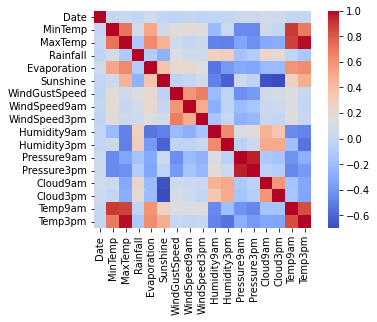

In [16]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

### Интерпретация
- Как видим минимальная температура `MinTemp` достаточно сильно коррелирует с максимальной MaxTemp, что очевидно, так как в жарком дне в среднем и минимальная и максимальная температура будут выше, а в холодном - ниже
- Также `MinTemp` и `MaxTemp` коррелируют с Temp9am и Temp3pm, что так же очевидно
- `Rainfall` слабо коререлирует с какими либо другими признаками. Наибольшая корреляция с `Humidity9am` и `Humidity3pm` (что очевидно - чем больше осадков, тем сильнее влажность), и с `Cloud9am` и `Cloud3pm` (чем облачнее, тем больше вероятность, что пойдет дождь)
- `Evaporation` (количество испарения из эвапорометра) коррелирует со всеми признаками связанными с температурой - чем выше температура, тем интенсивнее жидкость испаряется
- `Sunshine` так же коррелирует с признаками связанными с температурой - чем больше солнца, тем выше температура
- Признаки скорости ветра коррелируют только между собой, что очевидно так как ни от температуры, ни от давления, ни от других признаков они не зависят
- Коррелируют Humidity и Cloud - признаки влажности и облачности, что также связано с выпадением осадков
- И корреляция признаков, показывающих давление с другими признаками так же слабая

In [17]:
data.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,9299.000000,9195.000000,9222.000000,9090.000000,5260.000000,4803.000000,8632.000000,9192.000000,9086.000000,9148.000000,9005.000000,8353.000000,8364.000000,5656.000000,5411.000000,9188.000000,9052.000000
mean,1585.954941,12.167417,23.189341,1.983542,5.219867,7.618842,39.383341,13.792211,18.514968,69.134346,51.525486,1017.841626,1015.447310,4.438119,4.518573,16.922355,21.638179
std,906.852207,6.106759,6.659379,5.627129,3.371433,3.759404,12.509556,8.458473,8.395569,18.199476,20.073558,6.647434,6.567501,2.895478,2.724669,6.115939,6.491200
min,-98.000000,-2.900000,4.700000,0.000000,0.200000,0.000000,13.000000,0.000000,0.000000,13.000000,6.000000,998.200000,995.800000,0.000000,0.000000,0.700000,3.400000
25%,779.500000,7.700000,18.200000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.300000,1010.900000,1.000000,2.000000,12.500000,16.800000
50%,1643.000000,12.100000,22.600000,0.000000,4.600000,8.500000,37.000000,13.000000,17.000000,70.000000,52.000000,1017.800000,1015.400000,5.000000,5.000000,16.600000,21.100000
75%,2384.000000,16.500000,27.900000,0.800000,7.000000,10.600000,46.000000,19.000000,24.000000,83.000000,65.000000,1022.500000,1020.000000,7.000000,7.000000,21.200000,26.100000
max,3112.000000,26.600000,41.800000,51.400000,21.600000,13.500000,87.000000,44.000000,46.000000,100.000000,99.000000,1034.900000,1032.700000,8.000000,8.000000,32.400000,40.500000


##  Обрабатываем пропущенные значения

В данных присутствуют пропущенные значения:

In [18]:
data.isna().sum()

Date                0
Location            0
MinTemp           104
MaxTemp            77
Rainfall          209
Evaporation      4039
Sunshine         4496
WindGustDir       669
WindGustSpeed     667
WindDir9am        651
WindDir3pm        286
WindSpeed9am      107
WindSpeed3pm      213
Humidity9am       151
Humidity3pm       294
Pressure9am       946
Pressure3pm       935
Cloud9am         3643
Cloud3pm         3888
Temp9am           111
Temp3pm           247
RainToday         209
RainTomorrow      226
dtype: int64

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам:

In [19]:
data.fillna(data.median(axis = 0), axis=0 , inplace=True)

In [20]:
data.isna().sum()

Date               0
Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustDir      669
WindGustSpeed      0
WindDir9am       651
WindDir3pm       286
WindSpeed9am       0
WindSpeed3pm       0
Humidity9am        0
Humidity3pm        0
Pressure9am        0
Pressure3pm        0
Cloud9am           0
Cloud3pm           0
Temp9am            0
Temp3pm            0
RainToday        209
RainTomorrow     226
dtype: int64

Пропущенные значения в столбцах, соответствующих категориальным признакам, заполним модой:

In [21]:
for c in categorical_columns:
    data[c].fillna(data[c].mode().iloc[0], inplace=True)

In [22]:
data.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

## Векторизация

Обработка категориальных признаков

In [23]:
data_describe = data.describe(include = [object])
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['RainToday', 'RainTomorrow'] ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [24]:
data['RainToday'].unique()

array(['No', 'Yes'], dtype=object)

In [25]:
data.at[data['RainToday'] == 'No', 'RainToday'] = 0
data.at[data['RainToday'] == 'Yes', 'RainToday'] = 1
data['RainToday'].describe()

count     9299
unique       2
top          0
freq      7272
Name: RainToday, dtype: int64

К небинарными признакам применим метод _векторизации_, 
который заключается в следующем.

Признак `j`, принимающий `s` значений, заменим на `s` признаков, принимащих значения `0` или `1`,
в зависимости от того, чему равно значение исходного признака `j`.

In [26]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Location_Adelaide', 'Location_Albany', 'Location_Albury',
       'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat',
       'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns',
       'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour',
       'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast',
       'Location_Hobart', 'Location_Katherine', 'Location_Launceston',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura',
       'Location_Moree', 'Location_MountGambier', 'Location_MountGinini',
       'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead',
       'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF',
       'Location_Penrith', 'Location_Perth', 'Location_PerthAirport',
       'Location_Portland', 'Location_Richmond', 'Location_Sale',
       'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport',
       'Location_Townsville', 'Location_Tuggeranong', 'Location_Ulur

## Нормализация количественных признаков

Многие алгоритмы машинного обучения чувствительны к масштабированию данных.
К таким алгоритмам, например, относится метод ближайших соседей, машина опорных векторов и др.

В этом случае количественные признаки полезно _нормализовать_.
Это можно делать разными способами.
Например, каждый количественный признак приведем к нулевому среднему и единичному среднеквадратичному отклонению:

In [27]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000,9299.000000
mean,1585.954941,12.166663,23.184461,1.938961,4.950629,8.044876,39.212388,13.783095,18.480267,69.148403,51.540488,1017.837391,1015.442553,4.658243,4.719862,16.918507,21.623884
std,906.852207,6.072514,6.631962,5.571291,2.554095,2.737342,12.068197,8.410087,8.301943,18.051423,19.753823,6.300215,6.228559,2.274691,2.091868,6.079424,6.404986
min,-98.000000,-2.900000,4.700000,0.000000,0.200000,0.000000,13.000000,0.000000,0.000000,13.000000,6.000000,998.200000,995.800000,0.000000,0.000000,0.700000,3.400000
25%,779.500000,7.800000,18.300000,0.000000,4.000000,8.300000,31.000000,7.000000,13.000000,57.000000,38.000000,1013.950000,1011.500000,3.000000,4.000000,12.500000,16.900000
50%,1643.000000,12.100000,22.600000,0.000000,4.600000,8.500000,37.000000,13.000000,17.000000,70.000000,52.000000,1017.800000,1015.400000,5.000000,5.000000,16.600000,21.100000
75%,2384.000000,16.500000,27.900000,0.600000,5.200000,8.600000,46.000000,19.000000,24.000000,82.000000,65.000000,1021.900000,1019.500000,6.000000,6.000000,21.100000,25.900000
max,3112.000000,26.600000,41.800000,51.400000,21.600000,13.500000,87.000000,44.000000,46.000000,100.000000,99.000000,1034.900000,1032.700000,8.000000,8.000000,32.400000,40.500000


In [28]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03,9.299000e+03
mean,8.957956e-17,-3.874498e-15,-3.365746e-15,-2.181656e-15,1.461591e-13,-6.961196e-15,-2.030912e-16,3.766031e-16,1.859883e-16,-6.041218e-16,-2.168153e-16,7.480270e-13,-2.708848e-12,-3.762897e-16,2.931065e-16,-7.300991e-15,-2.090815e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.856923e+00,-2.481124e+00,-2.787178e+00,-3.480273e-01,-1.860005e+00,-2.938937e+00,-2.172022e+00,-1.638877e+00,-2.226017e+00,-3.110470e+00,-2.305401e+00,-3.116940e+00,-3.153627e+00,-2.047857e+00,-2.256290e+00,-2.667770e+00,-2.845265e+00
25%,-8.892904e-01,-7.190865e-01,-7.365031e-01,-3.480273e-01,-3.721980e-01,9.320145e-02,-6.804984e-01,-8.065428e-01,-6.601186e-01,-6.729887e-01,-6.854616e-01,-6.170251e-01,-6.329800e-01,-7.289969e-01,-3.441241e-01,-7.267970e-01,-7.375324e-01
50%,6.290447e-02,-1.097784e-02,-8.812787e-02,-3.480273e-01,-1.372811e-01,1.662650e-01,-1.833239e-01,-9.311377e-02,-1.783036e-01,4.717617e-02,2.326192e-02,-5.934895e-03,-6.831912e-03,1.502433e-01,1.339174e-01,-5.239104e-02,-8.179320e-02
75%,8.800167e-01,7.135985e-01,7.110323e-01,-2.403323e-01,9.763570e-02,2.027968e-01,5.624379e-01,6.203152e-01,6.648725e-01,7.119437e-01,6.813624e-01,6.448365e-01,6.514263e-01,5.898635e-01,6.119590e-01,6.878106e-01,6.676230e-01
max,1.682794e+00,2.376830e+00,2.806943e+00,8.877842e+00,6.518696e+00,1.992855e+00,3.959797e+00,3.592936e+00,3.314855e+00,1.709095e+00,2.402548e+00,2.708258e+00,2.770697e+00,1.469104e+00,1.568042e+00,2.546539e+00,2.947097e+00


## Соединяем все в одну таблицу

In [29]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

(9299, 116)


## Разбиение данных на обучающую и тестовую выборки

Для предсказания будем использовать все признаки.

In [30]:
X = data.drop('RainTomorrow', axis = 1)
y = data['RainTomorrow']

Разобьем данные на обучающую и тестовую выборки в пропорции 2:1 (67% - обучающая выборка, 33% - тестовая):

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

### Обучаем классификатор

In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42)

In [34]:
%%time
mlp_model.fit(X_train, y_train)

CPU times: user 14.4 s, sys: 14 s, total: 28.4 s
Wall time: 14.6 s


MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

### Проверяем качество классификатора

In [35]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy_score(y_train, y_train_pred)

1.0

In [38]:
accuracy_score(y_test, y_test_pred)

0.7914630172694689

### Подбор _гипер_параметров

Подберем _оптимальное_ значение параметра регуляризации `alpha`

In [44]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

iterations = 0
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=2000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    iterations += 1
    print(iterations)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [50]:
print(alpha_arr)

[1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00 1.77827941e+00 3.16227766e+00 5.62341325e+00
 1.00000000e+01 1.77827941e+01 3.16227766e+01 5.62341325e+01
 1.00000000e+02]


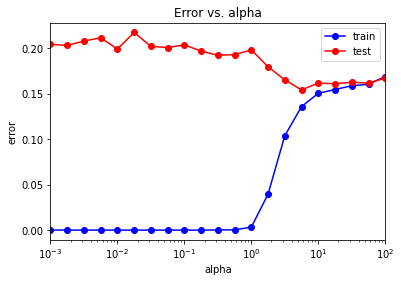

In [45]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

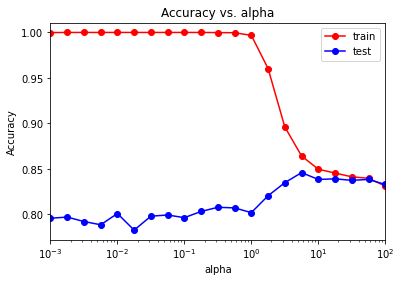

In [46]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальное значение ошибки:

In [47]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.15412186379928317


Оптимальное значение `alpha`:

In [48]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[5.62341325]


In [49]:
alpha_opt = alpha_opt[0]

### Классификатор при найденном _оптимальном_ значении `alpha`:

Повторим обучение:

In [53]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', max_iter=2000, random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.13579454253611556
0.15412186379928317


In [54]:
accuracy_score(y_train, y_train_pred)

0.8642054574638844

In [55]:
accuracy_score(y_test, y_test_pred)

0.8458781362007168

### Матрица рассогласования:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


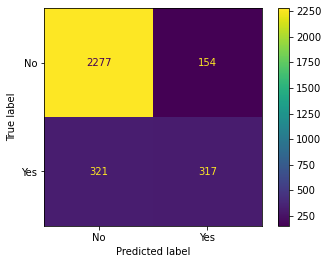

In [52]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test) 

### Подбор оптимального количества нейронов

In [97]:
neuron_count_arr = np.linspace(10, 300, 30).astype(int)
test_err = []
train_err = []
train_acc = []
test_acc = []

iterations = 0
for neuron_count in neuron_count_arr:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_count,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=2000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    iterations += 1
    print(iterations)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


**Рассмотрим как у нас менялась метрика в зависимости от числа нейронов:**

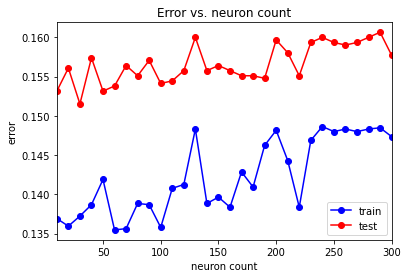

In [98]:
plt.plot(neuron_count_arr, train_err, 'b-o', label = 'train')
plt.plot(neuron_count_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neuron_count_arr), np.max(neuron_count_arr)])
plt.title('Error vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

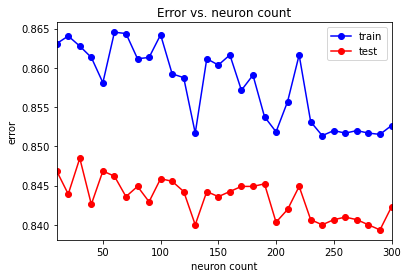

In [100]:
plt.plot(neuron_count_arr, train_acc, 'b-o', label = 'train')
plt.plot(neuron_count_arr, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(neuron_count_arr), np.max(neuron_count_arr)])
plt.title('Error vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

Минимальное значение ошибки:

In [101]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.13547351524879614 0.15151515151515152


Оптимальное значение количества нейронов:

In [102]:
neuron_opt = neuron_count_arr[test_err == min_test_err]
print(neuron_opt)

[30]


In [103]:
neuron_opt = neuron_opt[0]

### Классификатор при оптимальном значении количества нейронов:

Повторим обучение:

In [104]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=2000, random_state = 42)

mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.13723916532905298
0.15151515151515152


In [105]:
accuracy_score(y_train, y_train_pred)

0.862760834670947

In [106]:
accuracy_score(y_test, y_test_pred)

0.8484848484848485

### Матрица рассогласования:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


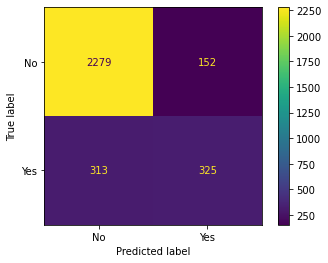

In [107]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test)